In [2]:
import sys
sys.path.append('/home/alvaro/python/reichlab/llmtime')
import os
os.environ['OMP_NUM_THREADS'] = '4'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openai
from data.serialize import SerializerSettings
from models.utils import grid_iter
from models.promptcast import get_promptcast_predictions_data
from models.darts import get_arima_predictions_data
from models.llmtime import get_llmtime_predictions_data
from data.small_context import get_datasets
from models.validation_likelihood_tuning import get_autotuned_predictions_data

plt.style.use('ggplot')

openai.api_key = os.environ["OPENAI_API_KEY"]
openai.api_base = os.environ.get("OPENAI_API_BASE", "https://api.openai.com/v1")

# %load_ext autoreload
# %autoreload 2

def plot_preds(train, test, pred_dict, model_name, show_samples=False):
    pred = pred_dict['median']
    pred = pd.Series(pred, index=test.index)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(train)
    plt.plot(test, label='Truth', color='black')
    plt.plot(pred, label=model_name, color='purple')
    # shade 90% confidence interval
    samples = pred_dict['samples']
    lower = np.quantile(samples, 0.05, axis=0)
    upper = np.quantile(samples, 0.95, axis=0)
    plt.fill_between(pred.index, lower, upper, alpha=0.3, color='purple')
    if show_samples:
        samples = pred_dict['samples']
        # convert df to numpy array
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(pred.index, samples[i], color='purple', alpha=0.3, linewidth=1)
    plt.legend(loc='upper left')
    if 'NLL/D' in pred_dict:
        nll = pred_dict['NLL/D']
        if nll is not None:
            plt.text(0.03, 0.85, f'NLL/D: {nll:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

/home/alvaro/miniconda3/envs/llmtime/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/alvaro/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


## Define models ##

In [3]:
gpt4_hypers = dict(
    alpha=0.3,
    basic=True,
    temp=1.0,
    top_p=0.8,
    settings=SerializerSettings(base=10, prec=3, signed=True, time_sep=', ', bit_sep='', minus_sign='-')
)

gpt3_hypers = dict(
    temp=0.7,
    alpha=0.95,
    beta=0.3,
    basic=False,
    settings=SerializerSettings(base=10, prec=3, signed=True, half_bin_correction=True)
)


promptcast_hypers = dict(
    temp=0.7,
    settings=SerializerSettings(base=10, prec=0, signed=True, 
                                time_sep=', ',
                                bit_sep='',
                                plus_sign='',
                                minus_sign='-',
                                half_bin_correction=False,
                                decimal_point='')
)

arima_hypers = dict(p=[12,30], d=[1,2], q=[0])

model_hypers = {
    'LLMTime GPT-3.5': {'model': 'gpt-3.5-turbo-instruct', **gpt3_hypers},
    #'LLMTime GPT-4': {'model': 'gpt-4', **gpt4_hypers},
    #'LLMTime GPT-3': {'model': 'text-davinci-003', **gpt3_hypers},
    'PromptCast GPT-3': {'model': 'gpt-3.5-turbo-instruct', **promptcast_hypers},
    'ARIMA': arima_hypers,
    
}

model_predict_fns = {
    'LLMTime GPT-3.5': get_llmtime_predictions_data,
    #'LLMTime GPT-4': get_llmtime_predictions_data,
    'PromptCast GPT-3': get_promptcast_predictions_data,
    'ARIMA': get_arima_predictions_data,
}

model_names = list(model_predict_fns.keys())

## Running LLMTime and Visualizing Results ##

Running LLMTime GPT-3.5
hypers = [defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'})]
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:04<00:00,  4.48s/it]


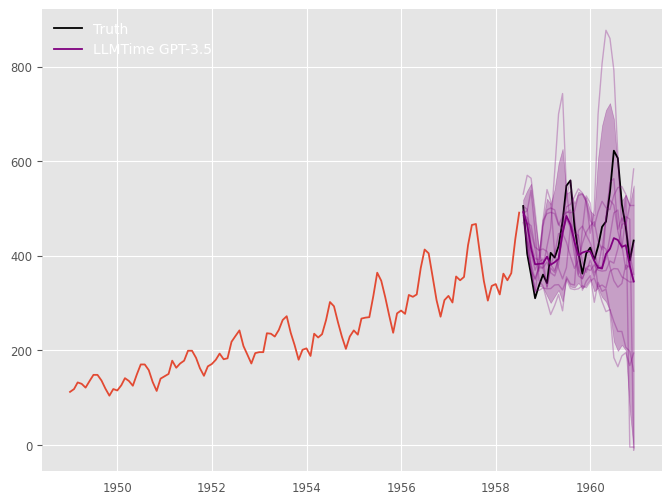

Running PromptCast GPT-3
hypers = [defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'settings': SerializerSettings(base=10, prec=0, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=False, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'})]
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'settings': SerializerSettings(base=10, prec=0, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=False, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


Got 10 properly formatted samples


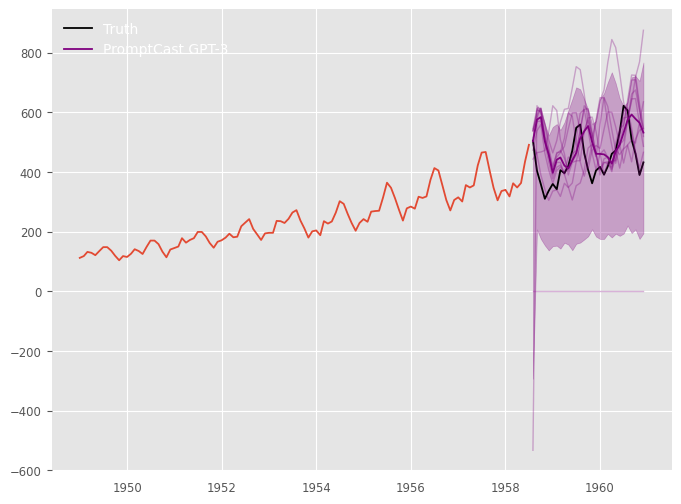

Running ARIMA
hypers = [defaultdict(<class 'dict'>, {'p': 12, 'd': 2, 'q': 0, 'dataset_name': 'AirPassengersDataset'}), defaultdict(<class 'dict'>, {'p': 12, 'd': 1, 'q': 0, 'dataset_name': 'AirPassengersDataset'}), defaultdict(<class 'dict'>, {'p': 30, 'd': 1, 'q': 0, 'dataset_name': 'AirPassengersDataset'}), defaultdict(<class 'dict'>, {'p': 30, 'd': 2, 'q': 0, 'dataset_name': 'AirPassengersDataset'})]
Train length: 86, Val length: 29


Hyperparameter search:   0%|          | 0/4 [00:00<?, ?it/s]/home/alvaro/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/alvaro/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alvaro/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/alvaro/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization

Sampling with best hyper... defaultdict(<class 'dict'>, {'p': 12, 'd': 2, 'q': 0, 'dataset_name': 'AirPassengersDataset'}) 
 with NLL 3.747898


/home/alvaro/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alvaro/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/alvaro/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


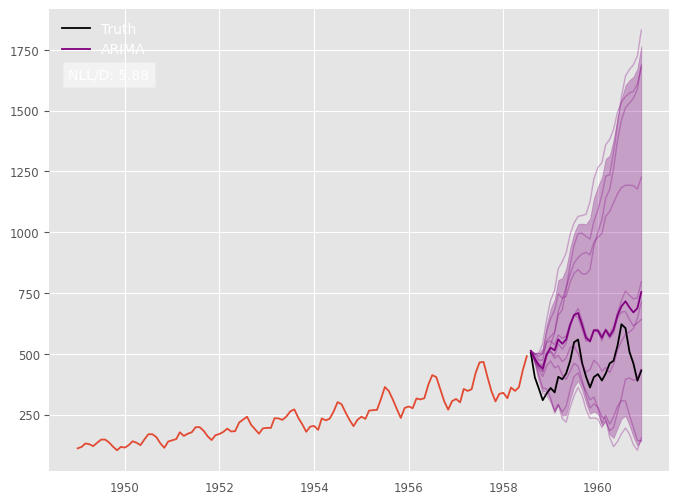

In [13]:
datasets = get_datasets()
ds_name = 'AirPassengersDataset'

data = datasets[ds_name]
train, test = data # or change to your own data
out = {}
for model in model_names: # GPT-4 takes a about a minute to run
    model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
    hypers = list(grid_iter(model_hypers[model]))
    num_samples = 10
    print(f'Running {model}')
    print(f'hypers = {hypers}')
    pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)
    out[model] = pred_dict
    plot_preds(train, test, pred_dict, model, show_samples=True)

In [17]:
# setting up train/test data
full_data = pd.read_csv("https://media.githubusercontent.com/media/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20Hospitalizations.csv")
us_data = full_data.query("location == 'US'")
train = us_data['value'][:-60]
test = us_data['value'][-60:]

In [30]:
full_data = pd.read_csv("https://media.githubusercontent.com/media/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20Hospitalizations.csv")
us_data = full_data.query("location == 'US'")
print(type(us_data))
print(us_data.head())
us_data.set_index('date', inplace=True)
print(type(us_data))
print(us_data.head())
pd.to_datetime(us_data.index)
us_data['value'].astype('float')
us_data.asfreq('D')
print(type(us_data))
print(us_data.head())

<class 'pandas.core.frame.DataFrame'>
             date location  location_name  value
73382  2020-07-27       US  United States   6100
73383  2020-07-28       US  United States   5257
73384  2020-07-29       US  United States   5387
73385  2020-07-30       US  United States   6288
73386  2020-07-31       US  United States   6034
<class 'pandas.core.frame.DataFrame'>
           location  location_name  value
date                                     
2020-07-27       US  United States   6100
2020-07-28       US  United States   5257
2020-07-29       US  United States   5387
2020-07-30       US  United States   6288
2020-07-31       US  United States   6034
<class 'pandas.core.frame.DataFrame'>
           location  location_name  value
date                                     
2020-07-27       US  United States   6100
2020-07-28       US  United States   5257
2020-07-29       US  United States   5387
2020-07-30       US  United States   6288
2020-07-31       US  United States   6034


In [15]:
# Figure out differences in data between hospital data and airpassenger data
# print(type(us_data))
# print(us_data.head()) 

covid_hosp_data = us_data['value']
print(covid_hosp_data.head())
covid_hosp_index = us_data['date']
print(covid_hosp_index.head())
print(type(covid_hosp_index))
covid_hosp = pd.Series(covid_hosp_data.values, index=covid_hosp_index.values, name='US_COVID_hosp')
covid_hosp = covid_hosp.astype(float)
covid_hosp.index = pd.to_datetime(covid_hosp.index)
covid_hosp = covid_hosp.asfreq('D')
print(type(covid_hosp))
print(covid_hosp.head())
print(len(covid_hosp))
train = covid_hosp.iloc[:int(len(covid_hosp)*0.8)]
print(len(train))
test = covid_hosp.iloc[int(len(covid_hosp)*0.8):]
print(len(test))
us_covid_hosp = (train, test)
print(type(us_covid_hosp))
print(type(data))
print(type(us_covid_hosp[0]))
print(type(data[0]))
print(len(data[0]))
print(us_covid_hosp[0].head())
print(data[0].head())
print(data[0][0])
print(us_covid_hosp[0].index[0])
print(data[0].index[0])
print(us_covid_hosp[0][-1])
print(data[0][-1])
print(us_covid_hosp[0].index[-1])
print(data[0].index[-1])
print(len(data[1]))
print(data[1].head())
print(data[1][0])
print(data[1].index[0])
print(data[1][-1])
print(data[1].index[-1])



72248    6100
72249    5257
72250    5387
72251    6288
72252    6034
Name: value, dtype: int64
72248    2020-07-27
72249    2020-07-28
72250    2020-07-29
72251    2020-07-30
72252    2020-07-31
Name: date, dtype: object
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
2020-07-27    6100.0
2020-07-28    5257.0
2020-07-29    5387.0
2020-07-30    6288.0
2020-07-31    6034.0
Freq: D, Name: US_COVID_hosp, dtype: float64
1328
1062
266
<class 'tuple'>
<class 'tuple'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
115
2020-07-27    6100.0
2020-07-28    5257.0
2020-07-29    5387.0
2020-07-30    6288.0
2020-07-31    6034.0
Freq: D, Name: US_COVID_hosp, dtype: float64
Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
Freq: MS, Name: #Passengers, dtype: float64
112.0
2020-07-27 00:00:00
1949-01-01 00:00:00
933.0
491.0
2023-06-23 00:00:00
1958-07-01 00:00:00
29
Month
1958-08-01    505.0
1958-09

/tmp/ipykernel_16402/1401420362.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(data[0][0])
/tmp/ipykernel_16402/1401420362.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(us_covid_hosp[0][-1])
/tmp/ipykernel_16402/1401420362.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(data[0][-1])
/tmp/ipykernel_16402/1401420362.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. I

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'US_COVID_hosp'}) 
 with NLL inf


100%|██████████| 1/1 [00:39<00:00, 39.40s/it]


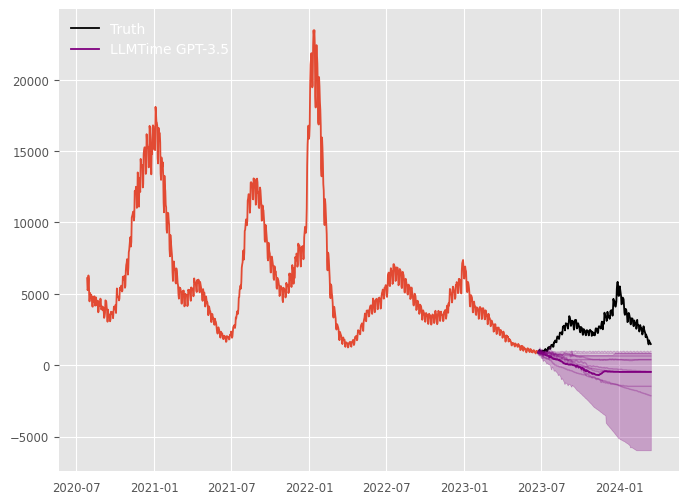

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'settings': SerializerSettings(base=10, prec=0, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=False, decimal_point='', missing_str=' Nan'), 'dataset_name': 'US_COVID_hosp'}) 
 with NLL inf
Truncated train to 1062 --> 153 timesteps


100%|██████████| 1/1 [00:23<00:00, 23.43s/it]


Found invalid prediction
Found invalid prediction
Found invalid prediction
Found invalid prediction
Found invalid prediction
Found invalid prediction
Found invalid prediction
Found invalid prediction
Found invalid prediction
Found invalid prediction
Found invalid prediction
Found invalid prediction
Found invalid prediction
Found invalid prediction
Found invalid prediction
Found invalid prediction
Found invalid prediction
Found invalid prediction
Found invalid prediction
Found invalid prediction
Got 10 properly formatted samples


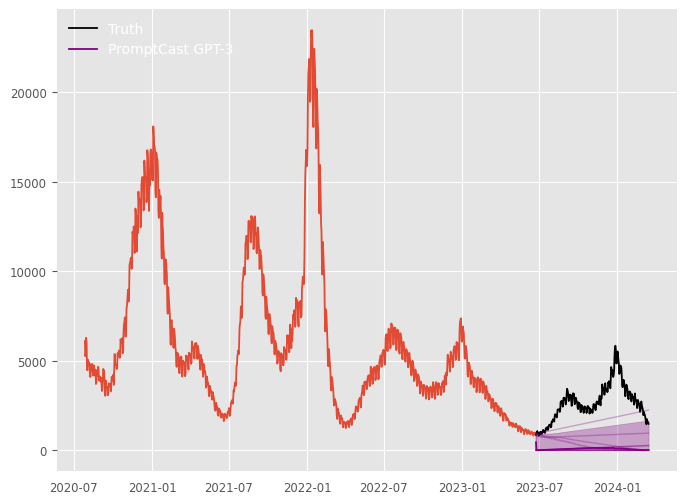

Train length: 796, Val length: 266


Hyperparameter search:  75%|███████▌  | 3/4 [00:21<00:08,  8.62s/it]/home/alvaro/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alvaro/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Hyperparameter search: 100%|██████████| 4/4 [00:46<00:00, 11.70s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'p': 30, 'd': 1, 'q': 0, 'dataset_name': 'US_COVID_hosp'}) 
 with NLL 6.910274


/home/alvaro/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alvaro/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


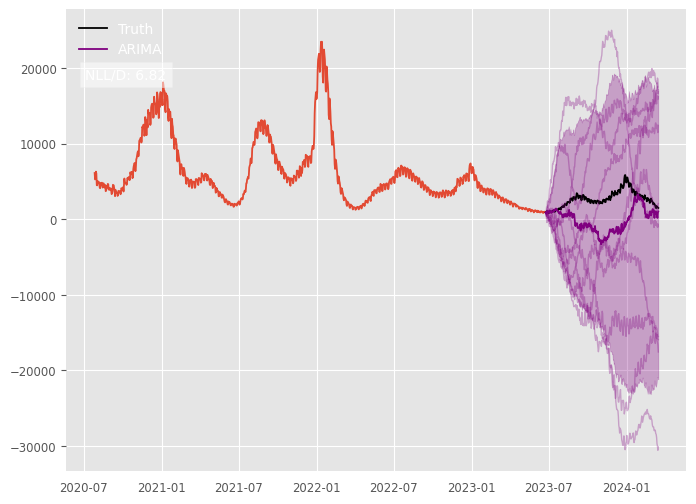

In [17]:
# the below is copy/pasted from the demo notebook
# datasets = get_datasets()
ds_name = 'US_COVID_hosp'

data = us_covid_hosp

out = {}
for model in model_names: # GPT-4 takes a about a minute to run
    model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
    hypers = list(grid_iter(model_hypers[model]))
    num_samples = 30
    pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)
    out[model] = pred_dict
    plot_preds(train, test, pred_dict, model, show_samples=True)